# iMinuit for LSQ


In this notebook we will learn how to use using iminuit (use as example a LSQ fit).

iMinuit:  
https://iminuit.readthedocs.io/en/latest/index.html#

iminuit is a Python frontend to the Minuit library in C++, an integrated software that combines a 
local minimizer (called Migrad) and two error calculators (called Hesse and the Minos). 
You provide it an analytical function, which accepts one or several parameters, and an initial guess 
of the parameter values. It will then find a local minimum of this function starting from the initial guess. 
In that regard, iminuit minimizer is like other local minimizers, like those in scipy.optimize.
In addition, iminuit has the ability to compute uncertainty estimates for model parameters. 
iminuit was designed to solve statistics problems, where uncertainty estimates are an essential part of 
the result. The two ways of computing uncertainty estimates, Hesse and the Minos, have different 
advantages and disadvantages.

To correctly compute the uncertainties, it needs to know if you are doing a max likelihood 
or a least squares fit:

errordef = 0.5 for negative log-likelihood functions

errordef = 1 for least-squares functions

Here below a quick summary of:  
https://iminuit.readthedocs.io/en/latest/tutorials.html  



In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from iminuit import Minuit

In [2]:
# Generate random numbers on a straight line
def line(x, a, b):
    return a + x * b

# generate random toy data with random offsets in y
np.random.seed(12345)
data_x = np.linspace(0, 1, 10)

data_yerr = 0.1  # could also be an array
data_y = line(data_x, 1, 2) + data_yerr * np.random.randn(len(data_x))

# draw toy data
plt.errorbar(data_x, data_y, data_yerr, fmt="o")
plt.xlim(-0.1, 1.1);

In [3]:
# Definition of the loss function you want to minimize (here the LSQ)

def least_squares(a, b):
    yvar = 0.01
    return sum((data_y - line(data_x, a, b)) ** 2 / yvar)

# Minuit

In [4]:
# configure minuit
m = Minuit(least_squares, 
           a=5, b=5
          )


m.errors = (0.1, 0.1)

m.limits['a']=(0,None)
m.limits['a']=(0,10)

In [5]:
# Once Minuit is constructed you can still fix/release parameters as:
m.fixed["a"] = False
m.fixed["b"] = True

# Trick to run over all parameters:
for key in m.fixed:
    m.fixed[key] = False
m.migrad()

# To change the value of a fixed parameter (or reset it to a different value) you can access it as:
m.values["a"] = 0.5

# errordef = 1 for least-squares functions
m.errordef=Minuit.LEAST_SQUARES

<ipython-input-5-7b2ad77f40c8>:8: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m.migrad()


# MIGRAD

In [6]:
# Migrad performs Variable-Metric Minimization. It combines a steepest-descends algorithm along with 
# line search strategy. Migrad is very popular in high energy physics field because of its robustness.
m.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 5.17                       │              Nfcn = 108              │
│ EDM = 1.69e-07 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   0.99    │   0.06    │            │            │    0    │   10    │       │
│ 1 │ b    │   2.11    │   0.10    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────┐
│   │        a        b │
├───┼───────────────────┤
│ a │  0.00345 -0.00491 │
│ b │ -0.00491  0.00982 │
└───┴───────────────────┘

In [7]:
# draw data and fitted line
plt.errorbar(data_x, data_y, data_yerr, fmt="o", label="data")
plt.plot(data_x, line(data_x, *m.values), label="fit")

# display legend with some fit info
fit_info = [
    f"$\\chi^2$ / $n_\\mathrm{{dof}}$ = {m.fval:.1f} / {len(data_x) - m.nfit}",    
]
for p, v, e in zip(m.parameters, m.values, m.errors):
    fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")

plt.legend(title="\n".join(fit_info))

In [8]:
from pprint import pprint

# To understand the results of the fit there are two dict-like objects:
# The first one is m.fmin
pprint (m.fmin)

# The most important one here is is_valid. If this is false, the fit did not converge and the result is useless !
#
# When is_valid = False it can be that the fit function is not analytical everywhere in the parameter space 
# or does not have a local minimum (the minimum may be at infinity, the extremum may be a saddle point 
# or maximum). Indicators for this are:
#   is_above_max_edm=True
#   hesse_failed=True
#   has_posdef_covar=False
#   has_made_posdef_covar=True
#
# Migrad reached the call limit before the convergence so that has_reached_call_limit=True. 
# The used number of function calls is nfcn, and the call limit can be changed with the keyword argument ncall 
# in the method Minuit.migrad
#
# Migrad detects converge by a small edm value, the estimated distance to minimum. This is the difference between
# the current minimum value of the minimized function and the next prediction based on a local quadratic 
# approximation of the function (something that Migrad computes as part of its algorithm). If the fit did not 
# converge, is_above_max_edm is true.
#
# To have a reliable uncertainty determination, you should make sure that:
# has_covariance        = True
# has_accurate_covar    = True
# has_posdef_covar      = True
# has_made_posdef_covar = False 
# hesse_failed          = False


<FMin edm=1.68928833640467e-07 edm_goal=0.0002 errordef=1.0 fval=5.1703973880091745 has_accurate_covar=True has_covariance=True has_made_posdef_covar=False has_parameters_at_limit=False has_posdef_covar=True has_reached_call_limit=False has_valid_parameters=True hesse_failed=False is_above_max_edm=False is_valid=True nfcn=108 ngrad=0>


In [9]:
# The second one is a list o|f dict-like objects which contain information about the fitted parameters:
pprint(m.params)

# Important fields are:
#   number: parameter index.
#   name: parameter name.
#   value: value of the parameter at the minimum.
#   error: uncertainty estimate for the parameter value.

(Param(number=0, name='a', value=0.9936315522776951, error=0.058773097349295256, merror=None, is_const=False, is_fixed=False, has_limits=True, has_lower_limit=True, has_upper_limit=True, lower_limit=0.0, upper_limit=10.0),
 Param(number=1, name='b', value=2.1116927803637497, error=0.09908913711329649, merror=None, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None))


# Hesse

In [10]:
# The Hesse algorithm numerically computes the matrix of second derivatives at the function minimum 
# (called the Hessian matrix) and inverts it.
# Pros:
#   (Comparably) fast computation.
#   Provides covariance matrix for error propagation.
# Cons:
#   Wrong if function does not look like a hyperparabola around the minimum

m.hesse()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 5.17                       │              Nfcn = 118              │
│ EDM = 1.69e-07 (Goal: 0.1)       │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   0.99    │   0.06    │            │            │    0    │   10    │       │
│ 1 │ b    │   2.11    │   0.10    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────┐
│   │        a        b │
├───┼───────────────────┤
│ a │  0.00345 -0.00491 │
│ b │ -0.00491  0.00982 │
└───┴───────────────────┘

In [11]:
# Covariance - colored table
m.covariance

┌───┬───────────────────┐
│   │        a        b │
├───┼───────────────────┤
│ a │  0.00345 -0.00491 │
│ b │ -0.00491  0.00982 │
└───┴───────────────────┘

In [12]:
# to access the matrix
cov = m.covariance
print (cov[0,0], cov[0,1], cov[1,0], cov[1,1]) 

0.003454603157553162 -0.00490918084413303 -0.00490918084413303 0.009818320746341605


In [13]:
# Correlation - colored table
m.covariance.correlation()

┌───┬───────────────┐
│   │      a      b │
├───┼───────────────┤
│ a │      1 -0.843 │
│ b │ -0.843      1 │
└───┴───────────────┘

In [14]:

# to access the matrix
corr = m.covariance.correlation()
print (corr[0,0], corr[0,1], corr[1,0], corr[1,1]) 

1.0000000000000002 -0.8429296692320603 -0.8429296692320603 1.0000000000000002


# Minos

In [15]:
# Minos implements the so-called profile likelihood method, where the neighborhood around the function minimum 
# is scanned until the contour is found where the function increase by the value of errordef. 
# Pros:
#  Good for functions which are not very close to a hyper-parabola around the minimum
#  Produces pretty confidence regions for scientific plots
# Cons:
#  Takes really long time
#  Result is difficult to error-propagate, since it cannot be described by a covariance matrix
#
# The results contain information as:
#  At Limit: Whether Minos hit a parameter limit before the finishing the contour.
#  Max FCN: Whether Minos reached the maximum number of allowed calls before finishing the contour.
#  New Min: Whether Minos discovered a deeper local minimum in the neighborhood of the current one.

In [16]:
m.minos()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 5.17                       │              Nfcn = 150              │
│ EDM = 1.69e-07 (Goal: 0.1)       │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   0.99    │   0.06    │   -0.06    │    0.06    │    0    │   10    │       │
│ 1 │ b    │   2.11    │   0.10    │   -0.10    │    0.10    │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┐
│          │           a           │           b           │
├──────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │   -0.06   │   0.06    │   -0.1    │    0.1    │
│  Valid   │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┘
┌───┬───────────────────┐
│   │        a        b │
├───┼───────────────────┤
│ a │  0.00345 -0.00491 │
│ b │ -0.00491  0.00982 │
└───┴───────────────────┘

In [17]:
pprint(m.params)

(Param(number=0, name='a', value=0.9936315522776951, error=0.05877209075352857, merror=(-0.05875139483449649, 0.05879939742618879), is_const=False, is_fixed=False, has_limits=True, has_lower_limit=True, has_upper_limit=True, lower_limit=0.0, upper_limit=10.0),
 Param(number=1, name='b', value=2.1116927803637497, error=0.09908743990204613, merror=(-0.09912332858924154, 0.09905013528814033), is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None))


In [18]:
# Other ways to access the fits results
pprint(m.values)
pprint(m.errors)
pprint(m.merrors) # The layout returned by Minuit.np_merrors() follows the convention 
                       # [abs(delta_down), delta_up] that is used by matplotlib.pyplot.errorbar.
pprint(m.covariance)

<ValueView a=0.9936315522776951 b=2.1116927803637497>
<ErrorView a=0.05877209075352857 b=0.09908743990204613>
{'a': <MError number=0 name='a' lower=-0.05875139483449649 upper=0.05879939742618879 is_valid=True lower_valid=True upper_valid=True at_lower_limit=False at_upper_limit=False at_lower_max_fcn=False at_upper_max_fcn=False lower_new_min=False upper_new_min=False nfcn=16 min=0.9936315522776951>,
 'b': <MError number=1 name='b' lower=-0.09912332858924154 upper=0.09905013528814033 is_valid=True lower_valid=True upper_valid=True at_lower_limit=False at_upper_limit=False at_lower_max_fcn=False at_upper_max_fcn=False lower_new_min=False upper_new_min=False nfcn=16 min=2.1116927803637497>}
[[ 0.0034546  -0.00490918]
 [-0.00490918  0.00981832]]


# Plot contours

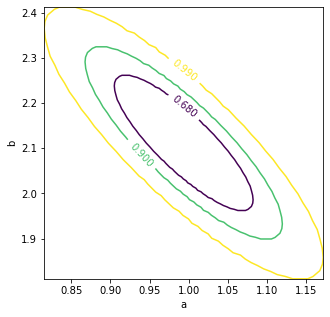

In [19]:
plt.figure(figsize=[5,5])
m.draw_mncontour('a','b', cl=(0.68, 0.9, 0.99), size=100)  

In [20]:
m.draw_profile('a');

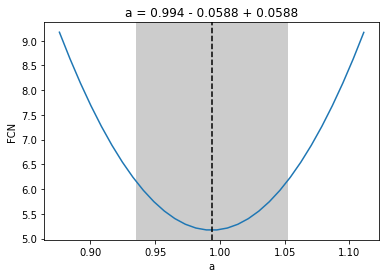

In [21]:
m.draw_mnprofile('a');

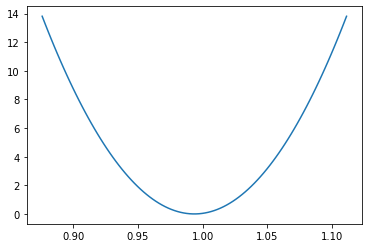

In [22]:
px, py = m.profile('a', subtract_min=True)
plt.plot(px, py);